## SECUREMAILING.VOICE

¿No estás cansado de que te roben la cuenta de correo o de robar correos tan fácilmente?

Te presentamos Securemailing.voice, tu deficiente app encargada de reconocerte a ti y solo a ti para enviar correos de una forma más segura.

Con, no solo uno, si no dos mecanismos de seguridad para garantizarte los estándares más elevados de seguridad de un país del tercer mundo, por el modico precio de 3 copilots.

--------------------------------------------------------------------------------

El objetivo de este proyecto es crear un pequeño programa capaz de identificar usuarios a partir de una voz y una contraseña únicas utilizando Machine Learning.
Para ello ofrece una interfaz gráfica con varias funciones básicas implementadas, tales como la creación de usuario y su inicio de sesión, gestión de credenciales y envío de correos.

Se utiliza una gran cantidad de tecnologías en el proyecto tales como MongoDB, PyQt, Cloud Speech o Machine Learning entre otras.

Si bien el Jupyter Notebook vale como una pequeña demo limitada para mostrar el proceso técnico que el programa usa, la versión en Python ofrece la interfaz gráfica y más libertad en las acciones a escoger.

Con esto dicho, vamos al meollo.

--------------------------------------------------------------------------------

El procedimiento a seguir en la demo es el siguiente:

- Creación de un usuario nuevo.
    - Toma de credenciales.
    - Toma de voz.
- Creación del modelo.
- Inicio de sesión.
- Envío de correo.
- Borrado de usuario.


### Creación de usuario

En este proceso se observa como los usuarios dan sus credenciales y su voz es grabada para ser registrados en la base de datos.
Inicialmente se debe conectar el programa con el servidor de la BD.


In [1]:
from pymongo import MongoClient
server = MongoClient('localhost', 27017)
db = server.users

Una vez conectado, se pregunta al usuario por sus credenciales.

In [2]:
import getpass
user = {}
print("Por favor, introduzca su nombre")
user["username"] = input()
print("Por favor, introduzca su contraseña")
user["password"] = getpass.getpass()
print("Por favor, introduzca su correo electrónico")
user["email"] = input()
print(user)

Por favor, introduzca su nombre
Por favor, introduzca su contraseña
Por favor, introduzca su correo electrónico
{'username': 'Luis ', 'password': 'Perro', 'email': 'lumunuera@alumnos.unex.es'}


Una vez obtenidas las credenciales se graba la voz del usuario.

In [3]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100
sd._initialize()
sd.default.samplerate = fs
sd.default.channels = 2
print("Por favor, lee la siguiente frase:")
print("Yo ofrezco desnudas, vírgenes, intactas y sencillas, para mis delicias y el placer de mis amigos, estas noches árabes vividas, soñadas y traducidas sobre su tierra natal y sobre el agua Ellas me fueron dulces durante los ocios en remotos mares, bajo un cielo ahora lejano. Por eso las doy.")
waveform = sd.rec(int(10 * fs), samplerate=fs, channels=2)
sd.wait()

write("audios/" + user["username"] + ".wav", fs, waveform)
print("\n¡Voz obtenida!")

Por favor, lee la siguiente frase:
Yo ofrezco desnudas, vírgenes, intactas y sencillas, para mis delicias y el placer de mis amigos, estas noches árabes vividas, soñadas y traducidas sobre su tierra natal y sobre el agua Ellas me fueron dulces durante los ocios en remotos mares, bajo un cielo ahora lejano. Por eso las doy.

¡Voz obtenida!


Ahora se extraen las features de la voz grabada, para ello nos ayudamos en librosa.
Se hacen algunos ajustes en el audio para que el tratamiento sea ligero.


¡Features obtenidas!


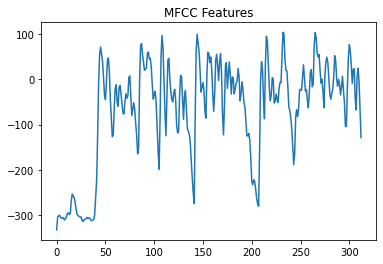

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

#Conversión del audio
waveform_mono = librosa.to_mono(waveform.T)
waveform16k_mono = librosa.resample(waveform_mono, orig_sr=fs, target_sr=16000)

#Obtención de features
obtFeatures = np.squeeze(librosa.feature.mfcc(y=waveform16k_mono, sr=16000, n_mfcc=1)).reshape(-1,1).reshape(1,-1)
np.savetxt("features/" + user["username"] + ".csv", obtFeatures)
print("\n¡Features obtenidas!")

plt.plot(obtFeatures[0])
plt.title("MFCC Features")
plt.show()

Con todos los datos necesarios conseguidos, solo queda introducirlos en la base de datos.

In [5]:
try:
    db.users.insert_one(user)
    print("¡Usuario creado!")
except:
    print("Ha ocurrido un problema")

¡Usuario creado!


Ahora hay que iniciar sesión, antes de poder hacerlo, hay que generar el modelo de prediccion de Machine Learning.

Con este fin, se cargan los archivos de features, un detalle importante es preservar el orden de carga de estos archivos para saber más tarde quién es el objetivo de la predicción del modelo.

In [6]:
import os
nameOrder = []; featureList = []

for filename in os.listdir(os.getcwd() + "/features"):
        features = np.loadtxt("features/" + filename, delimiter=" ")
        featureList.append(features)
        nameOrder.append(filename.replace(".csv", ""))

Con las features cargadas, se genera el modelo de predicción, se usa Gaussian Mixture, un modelo muy utilizado para diferenciar el contenido de las ondas.

In [7]:
from sklearn.mixture import GaussianMixture

gmmModel = GaussianMixture(n_components=len(featureList), covariance_type='full', tol=0.001, reg_covar=0.000001, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
gmmModel.fit(featureList)

GaussianMixture(n_components=2)

¡Ya está todo listo para que el usuario pueda iniciar sesión!

Recordamos, hay dos condiciones para que el usuario pueda iniciar sesión, ser reconocido por el sistema y decir su contraseña única.

Se graba su voz de nuevo y se extraen sus features.

In [8]:
from pydub import AudioSegment

print("Por favor, di tu contraseña")
detectedVoice = sd.rec(int(10 * fs), samplerate=fs, channels=2)
sd.wait()
print("\n¡Contraseña obtenida!")

write("features.wav", fs, detectedVoice)
detectedVoice_mono = librosa.to_mono(detectedVoice.T)
detectedVoice16k_mono = librosa.resample(detectedVoice_mono, orig_sr=fs, target_sr=16000)
detectedFeatures = np.squeeze(librosa.feature.mfcc(y=waveform16k_mono, sr=16000, n_mfcc=1)).reshape(-1,1).reshape(1,-1)

Por favor, di tu contraseña

¡Contraseña obtenida!


Ahora realizamos un pequeño hack para que funcione la API de Google.

In [9]:
#pequeño hack para que la API de Google funcione.
sound = AudioSegment.from_wav("features.wav")
sound.export("speech.wav", format="wav")

<_io.BufferedRandom name='speech.wav'>

Con las features obtenidas, el sistema detecta quién es y qué ha dicho.

In [10]:
import speech_recognition as sr
import unidecode

#Detección de usuario por voz
predictedUser = nameOrder[gmmModel.predict(detectedFeatures)[0]]
print("\n¡Usuario detectado: " + predictedUser + "!")

#Detección de contraseña por voz
speech_to_text = sr.Recognizer()
audio = sr.AudioFile('speech.wav')
with audio as source:
    audio = speech_to_text.record(audio)
    transcription = speech_to_text.recognize_google(audio, language="es-ES")
    print("\n¡Contraseña detectado: " + transcription + "!")


¡Usuario detectado: Luis!

¡Contraseña detectado: perro!


Ahora se comprueba en la base de datos si hay alguna coincidencia.

Para esto, se ve si la contraseña registrada en la base de datos tiene una alta similitud con la transcrita por Google.

In [11]:
from difflib import SequenceMatcher

correctUser = None
foundUser = None

for foundUser in db.users.find({"username": predictedUser}):
    ratio = SequenceMatcher(None, unidecode.unidecode(foundUser["password"].lower()), unidecode.unidecode(transcription.lower())).ratio()
    if ratio >= 0.8: correctUser = foundUser

if foundUser:
    user["username"] = foundUser["username"]
    user["password"] = foundUser["password"]
    user["email"] = foundUser["email"]
    print("Inicio de sesión correcto.")
else:
    print("Inicio de sesión fallido.")

Inicio de sesión correcto.


Si el usuario ha sido reconocido, éste puede realizar diferentes acciones, desde la gestión de credenciales hasta el envío de correos electrónicos.

In [12]:
from redmail import gmail

gmail.username = "diego.diegogz.gallardo53@gmail.com"
gmail.password = "xkdpshvcnlnscnhv"
print("Por favor introduce el asunto del correo texto a enviar")
subject = input()
print("Por favor introduce el destinatario del correo")
receiver = input()
print("Por favor introduce el contenido a enviar")
text = input()
gmail.send(subject=subject, receivers = [receiver], text = text, html = text)    

Por favor introduce el asunto del correo texto a enviar
Por favor introduce el destinatario del correo
Por favor introduce el contenido a enviar


Una vez se ha enviado el correo, se procede a borrar al usuario de la base de datos y sus archivos de audio y features.

In [13]:
db.users.delete_one(user)
os.remove("features/" + user["username"] + ".csv")
os.remove("audios/" + user["username"] + ".wav")